# Quantum Computing: Lab 2



## Working with real quantum devices (part 2)

After we have seen, how we can simulate existing quantum devices, we will now see how to run a quantum circuit on an existing quantum device.

In [1]:
from qiskit import *

# IBMQ.save_account('<API-Token>', hub='ibm-q', group='open', project='main', overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [2]:
from qiskit.providers.ibmq import least_busy

# get all real-hardware backends with more than one qubit
backends = list(filter(lambda device:device.configuration().num_qubits > 1, provider.backends(simulator=False, operational=True)))

lb_backend = least_busy(backends)    
print(lb_backend)

ibmq_quito


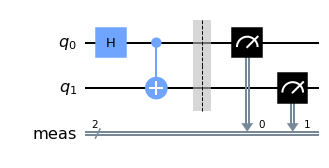

In [3]:
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

backend = BasicAer.get_backend('qasm_simulator')

bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cnot(0, 1)
bell_circuit.measure_all()
bell_circuit.draw('mpl')

In [4]:
job = execute(bell_circuit, backend, shots=1024)
bell_result = job.result()

In [5]:
bell_device_job = execute(bell_circuit, lb_backend, shots=1024)
bell_device_result = bell_device_job.result()
bell_device_result_counts = bell_device_result.get_counts(bell_circuit)

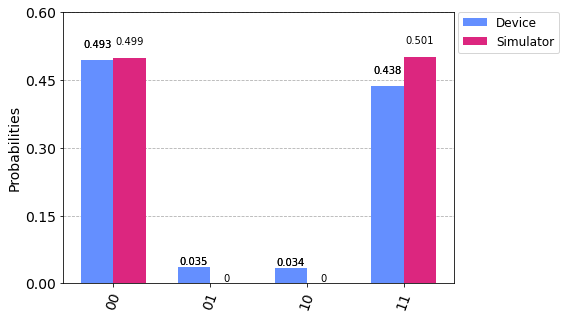

In [6]:
plot_histogram([bell_device_result_counts, bell_result.get_counts(bell_circuit)], legend=['Device', 'Simulator'])

## Developing the idea of quantum teleportation

- Alice has created a new hardware gate, which she wants to test
- Bob has a test lab, however Alice can't just bring her quantum computer to Bob
- Alice and Bob are far away from each other and thus want to exchange the state of a qubit, so that Bob can test it
- a classical copy is not possible, since it would involve measuring it and thus destroying its state

In [3]:
%matplotlib inline

from qiskit import *

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

import numpy as np

backend = BasicAer.get_backend('qasm_simulator')

But first let us create our "special" gate

In [5]:
u_matrix = np.array([[np.sqrt(3)/np.sqrt(4), 1/np.sqrt(4)], [1/np.sqrt(4), -np.sqrt(3)/np.sqrt(4)]])
special_gate = qiskit.extensions.UnitaryGate(u_matrix, label="special")

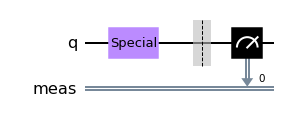

In [6]:
test_circuit = QuantumCircuit(1)
test_circuit.append(special_gate, [0]) # This is how we use our special gate
test_circuit.measure_all()
test_circuit.draw('mpl')

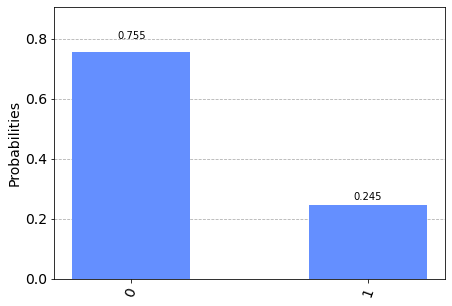

No measurements in circuit "circuit90", classical register will remain all zeros.


In [7]:
job_test = execute(test_circuit, backend, shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(test_circuit))

- to see more precisely what happens, we want to use the `statevector_simulator`

In [8]:
statevector_backend = Aer.get_backend('statevector_simulator')

In [9]:
test_circuit_0 = QuantumCircuit(2)
test_circuit_0.append(special_gate, [1])

job_0 = execute(test_circuit_0, statevector_backend, optimization_level=0)
result_0 = job_0.result()

outputstate_0 = result_0.get_statevector(test_circuit_0)

print(outputstate_0)
print("Probailities:")
print("0: " + str(np.absolute(outputstate_0[0]) ** 2))
print("1: " + str(np.absolute(outputstate_0[2]) ** 2))

[0.8660254+0.j 0.       +0.j 0.5      +0.j 0.       +0.j]
Probailities:
0: 0.7499999999999999
1: 0.25


__Exercise 1:__ Write a circuit `test_circuit_1`, which simulates (using the `statevector_backend`) a circuit with qubit 1 starting in state $|1\rangle$

In [10]:
# Your Code goes here

- to start with an easier problem we want to move (not swap!) the state $|\psi\rangle$ from one qubit to another

__Exercise 2:__ Entangle both qubits!

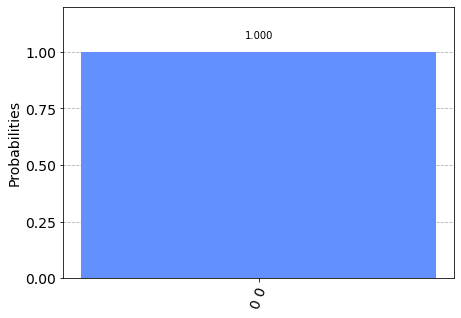

In [11]:
q_reg = QuantumRegister(2)
c_reg = ClassicalRegister(1)
result_reg = ClassicalRegister(1)

move_circuit = QuantumCircuit(q_reg, c_reg, result_reg)
move_circuit.append(special_gate, [0])

# Your Code here

move_circuit.measure(q_reg[1], result_reg[0])

job_move = execute(move_circuit, backend)
result_move = job_move.result()

plot_histogram(result_move.get_counts(move_circuit))

We start on qubit 0 with state $\alpha|0\rangle + \beta|1\rangle$ and state $|0\rangle$ on qubit 1. (Instead of explicit amplitudes, we just want to use $\alpha$ an $\beta$)
So our complete state is at the moment: $\alpha|00\rangle + \beta|10\rangle$. To get rid of unwanted qubits, we can simply just measure them.

__Exercise 3:__ Analyse the states of quantum circuit above using equations (e.g. on paper or here with $\LaTeX$). What happened so far and what would happen next if we measure (1) in the computational basis or (2) in the +/- basis?

Some hints: 
- $|0\rangle$ in the +/- basis is $\frac{1}{\sqrt{2}}|+\rangle + \frac{1}{\sqrt{2}}|-\rangle$
- after rewriting the equation, what is the state of the second qubit if we measure $|+\rangle$ or $|-\rangle$

__Exercise 4:__ On IBM quantum computers (and most others) we can only measure in the Z-Basis (the computational basis). How could we still be able to measure in the +/- Basis using a Z-measurement? Add the needed actions to your `move_circuit`.

__Exercise 5:__ As we have seen before, if we measure in the +/- basis only one of the outcomes is correct. What could we do to change the outcome of the other one to the correct wanted state? (Answer here in the Markdown Cell or on paper)

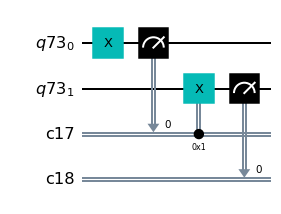

In [27]:
q_reg = QuantumRegister(2)
c_reg = ClassicalRegister(1)
c_reg2 = ClassicalRegister(1)

circ = QuantumCircuit(q_reg, c_reg, c_reg2)
circ.x(q_reg[0])
circ.measure(q_reg[0], c_reg[0])

circ.x(q_reg[1]).c_if(c_reg, 1)

circ.measure(q_reg[1], c_reg2[0])

circ.draw('mpl')

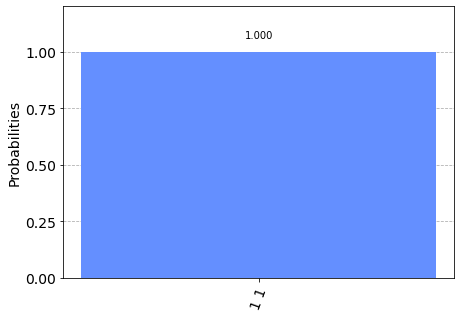

In [28]:
job_test = execute(circ, backend, shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(circ))

__Exercise 6:__ Implement the conditional gate in your `move_circuit` and measure with the `qasm_simulator`. Also plot the circuit.

In [37]:
from collections import defaultdict

def get_subsystems_counts(complete_system_counts, post_select_index=None, post_select_flag=None):
    """
    Extract all subsystems' counts from the single complete system count dictionary.
    If multiple classical registers are used to measure various parts of a quantum system,
    Each of the measurement dictionary's keys would contain spaces as delimiters to separate
    the various parts being measured. For example, you might have three keys
    '11 010', '01 011' and '11 011', among many other, in the count dictionary of the
    5-qubit complete system, and would like to get the two subsystems' counts
    (one 2-qubit, and the other 3-qubit) in order to get the counts for the 2-qubit
    partial measurement '11' or the 3-qubit partial measurement '011'.
    If the post_select_index and post_select_flag parameter are specified, the counts are
    returned subject to that specific post selection, that is, the counts for all subsystems where
    the subsystem at index post_select_index is equal to post_select_flag.
    Args:
        complete_system_counts (dict): The measurement count dictionary of a complete system
            that contains multiple classical registers for measurements s.t. the dictionary's
            keys have space delimiters.
        post_select_index (int): Optional, the index of the subsystem to apply the post selection
            to.
        post_select_flag (str): Optional, the post selection value to apply to the subsystem
            at index post_select_index.
    Returns:
        list: A list of measurement count dictionaries corresponding to
                each of the subsystems measured.
    """
    mixed_measurements = list(complete_system_counts)
    subsystems_counts = [defaultdict(int) for _ in mixed_measurements[0].split()]
    for mixed_measurement in mixed_measurements:
        count = complete_system_counts[mixed_measurement]
        subsystem_measurements = mixed_measurement.split()
        for k, d_l in zip(subsystem_measurements, subsystems_counts):
            if (post_select_index is None
                    or subsystem_measurements[post_select_index] == post_select_flag):
                d_l[k] += count
    return [dict(d) for d in subsystems_counts]

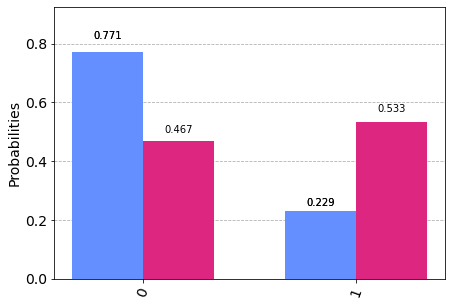

In [29]:
sub_result = get_subsystems_counts(result_move.get_counts(move_circuit))
plot_histogram(sub_result)

In [12]:
# draw the circuit

Unfortunately we can't have a CNOT-Gate reaching from Alice to Bob. So we need a synchronization between our qubit 1 and a qubit from Bob.

__Exercise 7:__ How could we synchronize 2 qubits on completely different locations?

__Exercise 8:__ Create a copy of your `move_circuit` here and implement your answer from exercise 7 on qubit 1 and 2 at the beginning of your circuit.

In [13]:
# Your code goes here

We now want to analyse the quantum circuit again, but without the measurements and the conditional gate.

We start in the following state: $\alpha|0\rangle + \beta|1\rangle(\frac{1}{\sqrt{2}}|00\rangle\frac{1}{\sqrt{2}}|11\rangle)$, which is the same as

$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|100\rangle + \frac{\beta}{\sqrt{2}}|111\rangle$, afterwards we still apply the CNOT-Gate from qubit 0 to qubit 1

$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|110\rangle + \frac{\beta}{\sqrt{2}}|101\rangle$

__Exercise 9:__ Create analyticly a measurement on qubit 1 (in either the computational basis or the +/- basis). Which conditional gate (if necessary) should be implemented to receive the following state: $\alpha|00\rangle + \beta|11\rangle$

__Exercise 10:__ So now we are back where we were at the beginning. So now you can stitch everything together and create a quantum circuit for the qunatum teleportation.

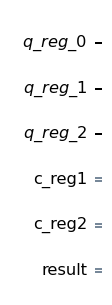

In [14]:
q_reg = QuantumRegister(3, name='q_reg')
c_reg1 = ClassicalRegister(1, name='c_reg1')
c_reg2 = ClassicalRegister(1, name='c_reg2')
result_reg = ClassicalRegister(1, name='result')

move_circuit = QuantumCircuit(q_reg, c_reg1, c_reg2, result_reg)

# Your Code goes here

move_circuit.draw('mpl')

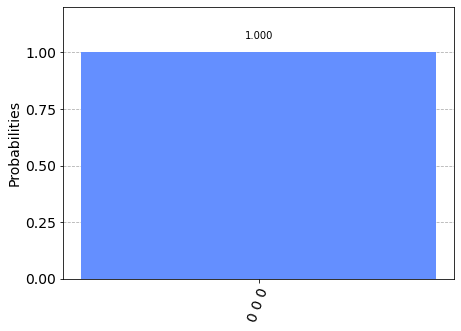

In [15]:
job_move = execute(move_circuit, backend)
result_move = job_move.result()

plot_histogram(result_move.get_counts(move_circuit))

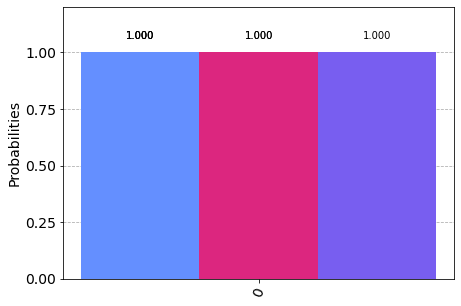

In [16]:
sub_result = get_subsystems_counts(result_move.get_counts(move_circuit))
plot_histogram(sub_result)

## Deutsch-Jozsa Algorithm

Use the [IBM Quantum Experience](https://quantum-computing.ibm.com/composer) to implement a quantum circuit of the Deutsch-Jozsa Algorithm with 3 qubits for the balanced case. The general quantum circuit for the Deutsch Jozsa Algorithm can be found in the figure below. **Note that the last qubit starsts with state $|1\rangle$**. Remember, that we only measure our $|x\rangle$ qubits. So ignore the state of the last qubit (when reading the classical register its the first one, since its mirrored).

<img src="resources/deutschjozsa.jpg" alt="Deutsch-Jozsa Algorithm" style="width: 700px;"/> 